In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
import cv2

In [26]:
try:
  %load_ext tensorboard
except:
  pass

In [2]:
def load_dataset():
    train = tfds.load('beans', split='train', shuffle_files=True)
    test = tfds.load('beans', split='test', shuffle_files=True)
    validation = tfds.load('beans', split='validation', shuffle_files=True)
    return train,validation,test

In [3]:
def resize_images(tensor):
    return tf.image.resize(tensor['image'], (140,140)), tensor['label']

In [4]:
def normalize_image(image, label):
    return image / 255.0 , label

In [5]:
def clean_dataset(train , validation,test):
    resized_train = train.map(map_func=resize_images)
    normalized_train = resized_train.map(map_func=normalize_image)

    resized_test = test.map(map_func=resize_images)
    normalized_test = resized_test.map(map_func=normalize_image)

    resized_validation = validation.map(map_func=resize_images)
    normalized_validation = resized_validation.map(map_func=normalize_image)

    return normalized_train,normalized_validation,normalized_test


In [6]:
train,validation,test = load_dataset()
normalized_train,normalized_validation,normalized_test = clean_dataset(train,validation,test)

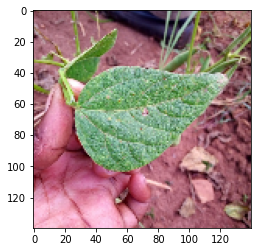

label for this image is : 1


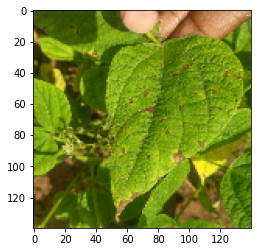

label for this image is : 0


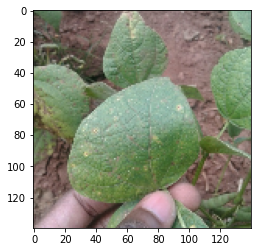

label for this image is : 1


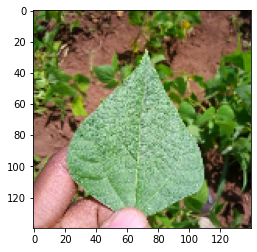

label for this image is : 2


In [7]:
for index, (image, label) in enumerate(normalized_train):
    plt.imshow(image)
    plt.show()
    print("label for this image is : " +(str(label.numpy())))
    if index >=3: 
        break

In [33]:
def create_batch_data(batch_size,train,validation,test):
    train_batch = train.repeat().batch(batch_size)
    test_batch = test.batch(batch_size)
    validation_batch = validation.batch(batch_size)

    return train_batch,validation_batch,test_batch

In [34]:
BATCH_SIZE = 16
batch_train , batch_validation,batch_test =create_batch_data(BATCH_SIZE,normalized_train,normalized_validation,normalized_test)

In [35]:
# create callback for tensorboard
tb_callback = keras.callbacks.TensorBoard(log_dir="logs/ann_hw4_2",histogram_freq=1)

In [36]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(140,140,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(64, activation='relu')(x)

output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

model.fit(batch_train,steps_per_epoch=len(normalized_train)/BATCH_SIZE, epochs=12,validation_data=batch_validation,callbacks=[tb_callback])
model.evaluate(batch_test)


Epoch 1/12


Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000022410A59B80>
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: deleter


64/64 [==============================] - 78s 1s/step - loss: 0.8904 - accuracy: 0.6240 - val_loss: 0.7667 - val_accuracy: 0.6917
Epoch 2/12
64/64 [==============================] - 55s 849ms/step - loss: 0.6107 - accuracy: 0.7558 - val_loss: 0.6207 - val_accuracy: 0.7519
Epoch 3/12
64/64 [==============================] - 55s 851ms/step - loss: 0.5774 - accuracy: 0.7558 - val_loss: 0.5576 - val_accuracy: 0.7744
Epoch 4/12
64/64 [==============================] - 56s 877ms/step - loss: 0.5432 - accuracy: 0.7923 - val_loss: 0.5389 - val_accuracy: 0.8195
Epoch 5/12
64/64 [==============================] - 72s 1s/step - loss: 0.4900 - accuracy: 0.7885 - val_loss: 0.5185 - val_accuracy: 0.8120
Epoch 6/12
64/64 [==============================] - 65s 1s/step - loss: 0.4340 - accuracy: 0.8375 - val_loss: 0.5731 - val_accuracy: 0.7820
Epoch 7/12
64/64 [==============================] - 73s 1s/step - loss: 0.4216 - accuracy: 0.8452 - val_loss: 0.6370 - val_accuracy: 0.7970
Epoch 8/12
64/64 [====

[0.7010140419006348, 0.7265625]

In [38]:
%tensorboard --logdir "logs/ann_hw4_2"

Reusing TensorBoard on port 6006 (pid 1812), started 0:00:32 ago. (Use '!kill 1812' to kill it.)

In [39]:
freeze_layers = 309
layer_num = len(model.layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

for layer in model.layers[freeze_layers:]:
    layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(batch_train,steps_per_epoch=len(normalized_train)/BATCH_SIZE, epochs=8,validation_data=batch_validation, shuffle=True,callbacks=[tb_callback])
model.evaluate(batch_test)

Epoch 1/8
64/64 [==============================] - 71s 937ms/step - loss: 0.2021 - accuracy: 0.9183 - val_loss: 0.5920 - val_accuracy: 0.8271
Epoch 2/8
64/64 [==============================] - 50s 784ms/step - loss: 0.2280 - accuracy: 0.9144 - val_loss: 0.8453 - val_accuracy: 0.8120
Epoch 3/8
64/64 [==============================] - 62s 959ms/step - loss: 0.2018 - accuracy: 0.9183 - val_loss: 0.5922 - val_accuracy: 0.8120
Epoch 4/8
64/64 [==============================] - 60s 939ms/step - loss: 0.2210 - accuracy: 0.9125 - val_loss: 0.6449 - val_accuracy: 0.7368
Epoch 5/8
64/64 [==============================] - 58s 907ms/step - loss: 0.1688 - accuracy: 0.9337 - val_loss: 0.4929 - val_accuracy: 0.8045
Epoch 6/8
64/64 [==============================] - 51s 788ms/step - loss: 0.1415 - accuracy: 0.9452 - val_loss: 0.7176 - val_accuracy: 0.8571
Epoch 7/8
64/64 [==============================] - 58s 893ms/step - loss: 0.1685 - accuracy: 0.9279 - val_loss: 0.8600 - val_accuracy: 0.7519
Epoch 

[0.9386229515075684, 0.7578125]

In [40]:
%tensorboard --logdir "logs/ann_hw4_2"

Reusing TensorBoard on port 6006 (pid 1812), started 0:12:06 ago. (Use '!kill 1812' to kill it.)

In [41]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(140,140,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(64, activation='relu')(x)

output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

model.fit(batch_train,steps_per_epoch=len(normalized_train)/BATCH_SIZE, epochs=12,validation_data=batch_validation,callbacks=[tb_callback])
model.evaluate(batch_test)


Epoch 1/12
64/64 [==============================] - 70s 853ms/step - loss: 0.9653 - accuracy: 0.5990 - val_loss: 0.6567 - val_accuracy: 0.7293
Epoch 2/12
64/64 [==============================] - 51s 801ms/step - loss: 0.6627 - accuracy: 0.7279 - val_loss: 0.6349 - val_accuracy: 0.7744
Epoch 3/12
64/64 [==============================] - 61s 958ms/step - loss: 0.5668 - accuracy: 0.7865 - val_loss: 0.5976 - val_accuracy: 0.7895
Epoch 4/12
64/64 [==============================] - 57s 893ms/step - loss: 0.5149 - accuracy: 0.7827 - val_loss: 0.5872 - val_accuracy: 0.7519
Epoch 5/12
64/64 [==============================] - 47s 726ms/step - loss: 0.3849 - accuracy: 0.8615 - val_loss: 0.7389 - val_accuracy: 0.7594
Epoch 6/12
64/64 [==============================] - 51s 794ms/step - loss: 0.4790 - accuracy: 0.8000 - val_loss: 0.7102 - val_accuracy: 0.6767
Epoch 7/12
64/64 [==============================] - 54s 846ms/step - loss: 0.4472 - accuracy: 0.8404 - val_loss: 0.7857 - val_accuracy: 0.6692

[0.8352056741714478, 0.75]

In [42]:
freeze_layers = 260
layer_num = len(model.layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

for layer in model.layers[freeze_layers:]:
    layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(batch_train,steps_per_epoch=len(normalized_train)/BATCH_SIZE, epochs=8,validation_data=batch_validation, shuffle=True,callbacks=[tb_callback])
model.evaluate(batch_test)

Epoch 1/8
64/64 [==============================] - 108s 1s/step - loss: 0.7902 - accuracy: 0.7154 - val_loss: 1.4823 - val_accuracy: 0.7444
Epoch 2/8
64/64 [==============================] - 84s 1s/step - loss: 0.3281 - accuracy: 0.8894 - val_loss: 0.6299 - val_accuracy: 0.8722
Epoch 3/8
64/64 [==============================] - 78s 1s/step - loss: 0.1939 - accuracy: 0.9337 - val_loss: 0.6680 - val_accuracy: 0.9173
Epoch 4/8
64/64 [==============================] - 75s 1s/step - loss: 0.1144 - accuracy: 0.9625 - val_loss: 0.8397 - val_accuracy: 0.8647
Epoch 5/8
64/64 [==============================] - 80s 1s/step - loss: 0.1542 - accuracy: 0.9490 - val_loss: 0.9131 - val_accuracy: 0.8722
Epoch 6/8
64/64 [==============================] - 83s 1s/step - loss: 0.0627 - accuracy: 0.9788 - val_loss: 0.6447 - val_accuracy: 0.8797
Epoch 7/8
64/64 [==============================] - 93s 1s/step - loss: 0.0684 - accuracy: 0.9769 - val_loss: 0.6386 - val_accuracy: 0.9098
Epoch 8/8
8/8 [===========

[0.5946823954582214, 0.8984375]

In [43]:
%tensorboard --logdir "logs/ann_hw4_2"

Reusing TensorBoard on port 6006 (pid 1812), started 0:58:58 ago. (Use '!kill 1812' to kill it.)

In [44]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(140,140,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(64, activation='relu')(x)

output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

model.fit(batch_train,steps_per_epoch=len(normalized_train)/BATCH_SIZE, epochs=12,validation_data=batch_validation)
model.evaluate(batch_test)


Epoch 1/12
64/64 [==============================] - 53s 698ms/step - loss: 0.8756 - accuracy: 0.6337 - val_loss: 0.8109 - val_accuracy: 0.6617
Epoch 2/12
64/64 [==============================] - 43s 674ms/step - loss: 0.6347 - accuracy: 0.7279 - val_loss: 0.5614 - val_accuracy: 0.8045
Epoch 3/12
64/64 [==============================] - 47s 736ms/step - loss: 0.5802 - accuracy: 0.7885 - val_loss: 0.5576 - val_accuracy: 0.7669
Epoch 4/12
64/64 [==============================] - 44s 677ms/step - loss: 0.4820 - accuracy: 0.8183 - val_loss: 0.7245 - val_accuracy: 0.7444
Epoch 5/12
64/64 [==============================] - 43s 666ms/step - loss: 0.4249 - accuracy: 0.8538 - val_loss: 0.6843 - val_accuracy: 0.7444
Epoch 6/12
64/64 [==============================] - 47s 728ms/step - loss: 0.5178 - accuracy: 0.8096 - val_loss: 0.5751 - val_accuracy: 0.7820
Epoch 7/12
64/64 [==============================] - 49s 754ms/step - loss: 0.3865 - accuracy: 0.8606 - val_loss: 0.4989 - val_accuracy: 0.8271

[0.6654613018035889, 0.796875]

In [45]:
freeze_layers = 240
layer_num = len(model.layers)
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

for layer in model.layers[freeze_layers:]:
    layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])
history = model.fit(batch_train,steps_per_epoch=len(normalized_train)/BATCH_SIZE, epochs=8,validation_data=batch_validation, shuffle=True,callbacks=[tb_callback])
model.evaluate(batch_test)

Epoch 1/8
64/64 [==============================] - 121s 2s/step - loss: 0.7044 - accuracy: 0.7288 - val_loss: 1.1382 - val_accuracy: 0.7143
Epoch 2/8
64/64 [==============================] - 102s 2s/step - loss: 0.3793 - accuracy: 0.8760 - val_loss: 0.4910 - val_accuracy: 0.7970
Epoch 3/8
64/64 [==============================] - 88s 1s/step - loss: 0.2209 - accuracy: 0.9279 - val_loss: 0.3054 - val_accuracy: 0.9098
Epoch 4/8
64/64 [==============================] - 98s 2s/step - loss: 0.1222 - accuracy: 0.9587 - val_loss: 0.4346 - val_accuracy: 0.8872
Epoch 5/8
64/64 [==============================] - 102s 2s/step - loss: 0.1199 - accuracy: 0.9712 - val_loss: 0.5385 - val_accuracy: 0.8797
Epoch 6/8
64/64 [==============================] - 101s 2s/step - loss: 0.0810 - accuracy: 0.9788 - val_loss: 0.4805 - val_accuracy: 0.8571
Epoch 7/8
64/64 [==============================] - 92s 1s/step - loss: 0.0653 - accuracy: 0.9827 - val_loss: 0.6507 - val_accuracy: 0.8647
Epoch 8/8
8/8 [========

[0.5370100140571594, 0.890625]

In [46]:
%tensorboard --logdir "logs/ann_hw4_2"

Reusing TensorBoard on port 6006 (pid 1812), started 1:25:47 ago. (Use '!kill 1812' to kill it.)